Implementing an Autoencoder in PyTorch
===

This is adapted from the workbook provided alongside the article "Implementing an Autoencoder in Pytorch" which can be found [here](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1). The primary differences are that the network is much larger (as the code is designed to work with much larger images) and the model is split into two parts to allow for differential encode/decode metrics such as Mahalanobis Distance.



## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
    platform = "cuda"
else:
    plaform = "cpu"

We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [3]:
width = 512
height = 512

image_size = width * height

batch_size = 64
epochs = 50
learning_rate = 1e-3

## Dataset

ImageFolder is used to load the base distribution images

In [4]:
from torchvision.datasets import ImageFolder

from torchvision.transforms import ToTensor
transform = torchvision.transforms.Compose([
     torchvision.transforms.Grayscale(),
     torchvision.transforms.Resize((width,height)),
     torchvision.transforms.ToTensor()])

root_dir = "../../Data/OPTIMAM_NEW/png_images"
train_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

## Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

In this version, our autoencoder is intentionally split into two parts so that the encoder and decoder can be used separately.

In [5]:
hidden_layer_size = 512
code_size = 256

In [6]:
class SplitAutoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=kwargs["input_shape"], out_features=hidden_layer_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer_size, out_features=hidden_layer_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer_size, out_features=code_size)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=code_size, out_features=hidden_layer_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer_size, out_features=hidden_layer_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer_size, out_features=image_size)
        )
        
    def forward(self, features):
        code = self.encoder(features)
        out = self.decoder(code)
        return out

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate our modules.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [7]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(platform)

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = SplitAutoencoder(input_shape=image_size).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()
#criterion = nn.BCELoss()

We train our autoencoder for our specified number of epochs.

In [8]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, image_size).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs,batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/20, recon loss = 0.05883137
epoch : 2/20, recon loss = 0.02051380
epoch : 3/20, recon loss = 0.01704820
epoch : 4/20, recon loss = 0.01826955
epoch : 5/20, recon loss = 0.01706547
epoch : 6/20, recon loss = 0.01853742
epoch : 7/20, recon loss = 0.01765114
epoch : 8/20, recon loss = 0.01620585
epoch : 9/20, recon loss = 0.01591451
epoch : 10/20, recon loss = 0.01550433
epoch : 11/20, recon loss = 0.02097776
epoch : 12/20, recon loss = 0.02427246
epoch : 13/20, recon loss = 0.03183318
epoch : 14/20, recon loss = 0.02377831
epoch : 15/20, recon loss = 0.02262218
epoch : 16/20, recon loss = 0.02240835
epoch : 17/20, recon loss = 0.02227230
epoch : 18/20, recon loss = 0.02264380
epoch : 19/20, recon loss = 0.02223764
epoch : 20/20, recon loss = 0.02212078


Let's extract some test examples to reconstruct using our trained autoencoder.

In [9]:


root_dir = "../../Data/OPTIMAM_NEW/png_images"
test_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transform) # same transform as we used for the training, for compatibility

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=5, shuffle=True
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, image_size).to(device)
        codes = model.encoder(test_examples)
        reconstruction = model(test_examples)
        break

## Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

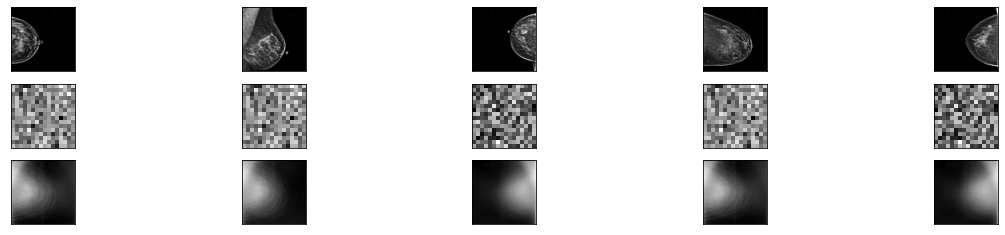

In [10]:
with torch.no_grad():
    number = 5
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(3, number, index + 1)
        copyback = test_examples[index].cpu()
        plt.imshow(copyback.numpy().reshape(height, width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display codes
        ax = plt.subplot(3, number, index + 1 + number)
        code_copyback = codes[index].cpu()
        plt.imshow(code_copyback.numpy().reshape(16, 16))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        ax = plt.subplot(3, number, index + 6 + number)
        recon_copyback = reconstruction[index].cpu()
        plt.imshow(recon_copyback.numpy().reshape(height, width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()